In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

sns.set_theme(style="darkgrid",palette=sns.color_palette("Set2"))

# load data

In [2]:
data=pd.read_csv("./Eastern_Africa-Middle_Africa-Northern_Africa-Southern_Africa-Western_Africa.csv")
data=data[['data_id','country','event_type','sub_event_type','fatalities','notes','region','latitude','longitude']]
data.head()

,data_id,country,event_type,sub_event_type,fatalities,notes,region,latitude,longitude
0,8166147,Democratic Republic of Congo,Battles,Armed clash,0,"On 1 June 2021, the ADF attacked a military ba...",Middle Africa,0.7821,29.6001
1,8166148,Sudan,Violence against civilians,Attack,5,"On 1 June 2021, three masked gunmen opened fir...",Northern Africa,15.5725,32.5364
2,8166410,Lesotho,Riots,Violent demonstration,0,"On 1 June 2021, workers pelted stones and loot...",Southern Africa,-29.3167,27.4833
3,8166411,Lesotho,Riots,Violent demonstration,0,"On 1 June 2021, workers set tires on fire and ...",Southern Africa,-28.8866,27.8991
4,8059405,Uganda,Violence against civilians,Attack,2,"On 1 June 2021, an unidentified armed group at...",Eastern Africa,0.3531,32.6000


# basic data explore

In [3]:
# number of records

print("event region count:",data.shape[0])
print("event region count:",data["region"].nunique())
print("event country count:",data["country"].nunique())
print("event type count:",data["event_type"].nunique())
print("event sub_event_type count:",data["sub_event_type"].nunique())

event region count: 33378
event region count: 5
event country count: 49
event type count: 6
event sub_event_type count: 24


In [4]:
data["event_type"].value_counts()

Protests                      11540
Battles                        7448
Violence against civilians     7141
Riots                          3928
Strategic developments         1778
Explosions/Remote violence     1543
Name: event_type, dtype: int64

In [5]:
# event distribution by event_type and region

region_event_count=data.pivot_table(index="region",
                 columns=["event_type"],
                 values="data_id",
                 aggfunc="count",
                 margins=True)

region_event_count

event_type,Battles,Explosions/Remote violence,Protests,Riots,Strategic developments,Violence against civilians,All
region,,,,,,,
Eastern Africa,3124,631,764,628,376,2130,7653
Middle Africa,2115,94,863,635,784,2092,6583
Northern Africa,375,306,6478,679,100,423,8361
Southern Africa,8,1,1436,826,17,143,2431
Western Africa,1826,511,1999,1160,501,2353,8350
All,7448,1543,11540,3928,1778,7141,33378


Comment#1： 

This table counts the number of event type that occur by region. Which region and which event type occur more

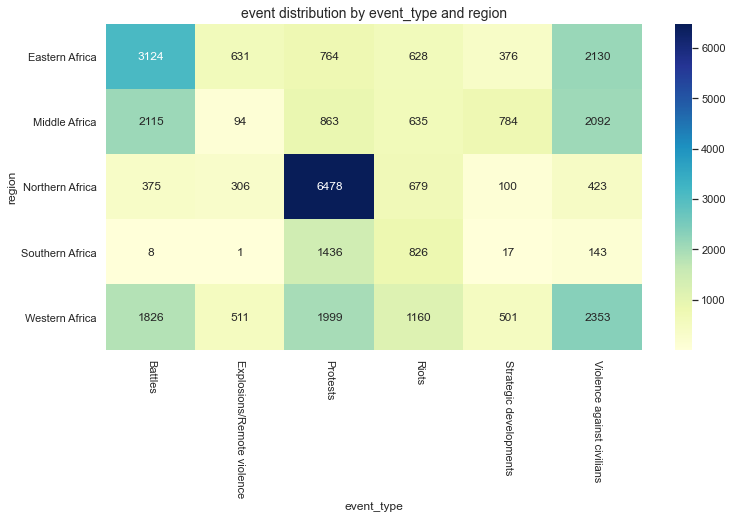

In [6]:
plt.figure(figsize=(12,6))

region_event_count2=data.pivot_table(index="region",
                 columns=["event_type"],
                 values="data_id",
                 aggfunc="count",
                 margins=False)

_=sns.heatmap(region_event_count2, 
            cmap="YlGnBu",
            annot=True,
              fmt='d')
_=plt.xticks(rotation=-90)
_=plt.title("event distribution by event_type and region",fontsize=14)

Comment#2:
    
To visualize the values from the previous statistics table, the darker the color, the more times the event occurred

In [7]:
# fatalities distribution by event_type and region

region_fatality_count=data.pivot_table(index="region",
                 columns=["event_type"],
                 values="fatalities",
                 aggfunc="sum",
                 margins=True)
region_fatality_count

event_type,Battles,Explosions/Remote violence,Protests,Riots,Strategic developments,Violence against civilians,All
region,,,,,,,
Eastern Africa,7513,1154,86,494,40,5248,14535
Middle Africa,5160,126,17,355,10,2948,8616
Northern Africa,1244,308,23,26,0,506,2107
Southern Africa,8,2,4,168,0,90,272
Western Africa,6944,1784,47,449,10,4245,13479
All,20869,3374,177,1492,60,13037,39009


Comment#3:

Event type: Number of casualties caused by event type fatalities, also used to measure the impact of what event in what place

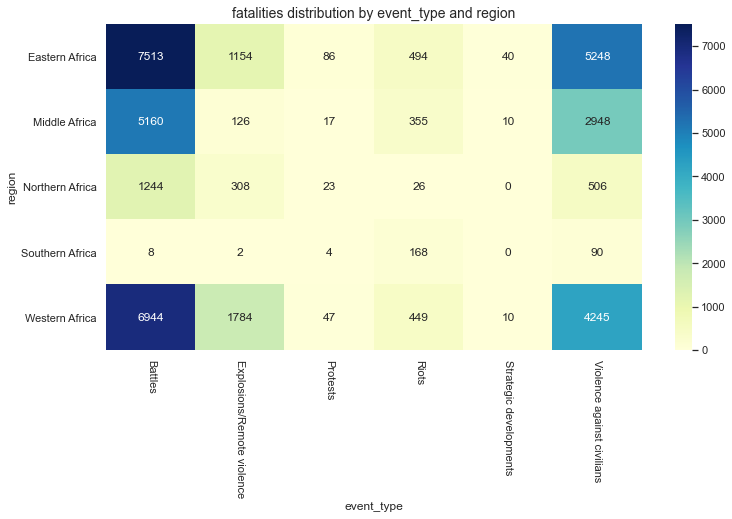

In [8]:
plt.figure(figsize=(12,6))

region_fatality_count2=data.pivot_table(index="region",
                 columns=["event_type"],
                 values="fatalities",
                 aggfunc="sum",
                 margins=False)

_=sns.heatmap(region_fatality_count2, 
            cmap="YlGnBu",
            annot=True,
              fmt='d')
_=plt.xticks(rotation=-90)
_=plt.title("fatalities distribution by event_type and region",fontsize=14)

Comment#4:

Again, visualize the data in the above table

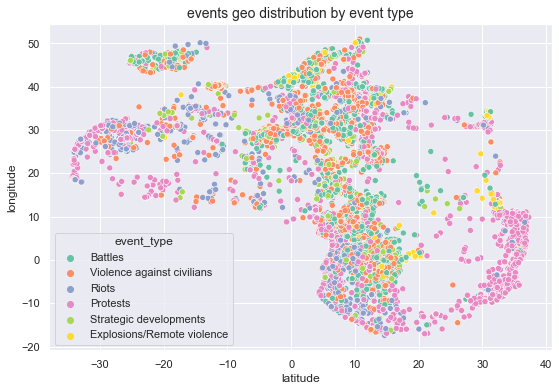

In [9]:
# event type distribution by geo

plt.figure(figsize=(9,6))
_=sns.scatterplot(x="latitude",
                  y="longitude",
                  hue="event_type",
                  data=data)
_=plt.title("events geo distribution by event type",fontsize=14)

Comment#5:
    
Events are shown by latitude and longitude, with different colors representing different types of events

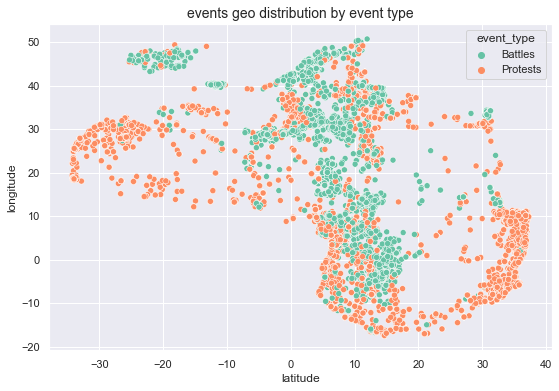

In [10]:
# if we only consider Protests and Battles type

plt.figure(figsize=(9,6))
_=sns.scatterplot(x="latitude",
                  y="longitude",
                  hue="event_type",
                  data=data[data["event_type"].isin(["Protests","Battles"])])
_=plt.title("events geo distribution by event type",fontsize=14)

Comment#6:
    
The same latitude and longitude is shown, but only the "Protests" and "Battles" event types are included here, because I see that your crew has only cleaned the data for these two events

# clean notes

+ Take out the data that will be used for modeling, do cleaning feature engineering, etc
+ x=notes y=event_type

In [11]:
import re
import string  
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize,pos_tag
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer

In [12]:
data_sub=data[["event_type","notes"]].copy()

In [13]:
# remove date info in notes

data_sub["notes"].map(lambda x: x.split(",")[0]).value_counts().head()

On 21 October 2020      143
On 19 October 2020      135
On 21 May 2021          133
On 21 September 2020    128
On 31 October 2020      125
Name: notes, dtype: int64

In [14]:
# What it looks like when it's gone

data_sub["notes"].map(lambda x: ",".join(x.split(",")[1:])).head()

0     the ADF attacked a military base in the villa...
1     three masked gunmen opened fire against civil...
2     workers pelted stones and looted shops in the...
3     workers set tires on fire and blocked roads i...
4     an unidentified armed group attacked the Mini...
Name: notes, dtype: object

In [15]:
data_sub["notes"]=data_sub["notes"].map(lambda x: ",".join(x.split(",")[1:]))

In [16]:
data_sub.head()

,event_type,notes
0,Battles,the ADF attacked a military base in the villa...
1,Violence against civilians,three masked gunmen opened fire against civil...
2,Riots,workers pelted stones and looted shops in the...
3,Riots,workers set tires on fire and blocked roads i...
4,Violence against civilians,an unidentified armed group attacked the Mini...


Comment#7:
    
Here is the description of the date before the notes, because I look at the first sentence of every Notes is the time, so the first comma before the first comma is removed according to the position of the first comma

In [17]:
# define cleaning function 

# Remove extra space, word segmentation, part-of-speech tagging
def tokenize(sentence):
    sentence = re.sub(r'\s+', ' ', sentence)
    token_words = word_tokenize(sentence)
    token_words = pos_tag(token_words)   
    return token_words

# Normalize the word form
def stem(token_words):
    wordnet_lematizer = WordNetLemmatizer()
    words_lematizer = []
    for word, tag in token_words:
        if tag.startswith('NN'):
            word_lematizer =  wordnet_lematizer.lemmatize(word, pos='n')  # n-noun
        elif tag.startswith('VB'): 
            word_lematizer =  wordnet_lematizer.lemmatize(word, pos='v')   # v-verb
        elif tag.startswith('JJ'): 
            word_lematizer =  wordnet_lematizer.lemmatize(word, pos='a')   # adjective
        elif tag.startswith('R'): 
            word_lematizer =  wordnet_lematizer.lemmatize(word, pos='r')   # r-pronoun
        else: 
            word_lematizer =  wordnet_lematizer.lemmatize(word)
        words_lematizer.append(word_lematizer)
    return words_lematizer

# Remove stopwords 
def delete_stopwords(token_words):
    cleaned_words = [word for word in token_words if word not in stopwords.words('english')]
    return cleaned_words

# Determine whether the string is a number
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
 
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
 
    return False

# Remove Special words and numbers
def delete_characters(token_words):
    words_list = [word for word in token_words if word not in string.punctuation and not is_number(word)]
    return words_list

# Change to lowercase
def to_lower(token_words):
    words_lists = [x.lower() for x in token_words]
    return words_lists

# Combine the above steps and perform text preprocessing
def pre_process(text):
    token_words = tokenize(text)
    token_words = to_lower(token_words)
    token_words = stem(token_words)    
    token_words = delete_stopwords(token_words)
    token_words = delete_characters(token_words)    
    cleaned_text=" ".join(token_words)
    return cleaned_text

Comment#8:
    
To clean the text in Notes using the NLTK package, do the following:
1. Tokenize: Use the word_tokenize participle first, followed by pos_tag for each word
2. Lemmatize: Use WordNetLemmatizer to restore lemmatize to the result of the previous participle
3. Remove stopwords: the definition of stopwords is the English stopwords defined in NLTK. Corpus
4. Remove punctuation or numbers. Punctuation is defined as the punctuation contained in string. string
5. Keep all the words in lower case
6. Finally merge the cleaned words into a piece of text with Spaces separating each word.
The above code defines each cleaning step as a function that is called to perform the cleaning

In [18]:
# apply clean

data_sub["notes_clean"]=data_sub["notes"].map(lambda x: pre_process(x))
data_sub.head()

,event_type,notes,notes_clean
0,Battles,the ADF attacked a military base in the villa...,adf attack military base village kokola locate...
1,Violence against civilians,three masked gunmen opened fire against civil...,three mask gunman open fire civilian gather ar...
2,Riots,workers pelted stones and looted shops in the...,worker pelt stone looted shop thetsane industr...
3,Riots,workers set tires on fire and blocked roads i...,worker set tire fire block road maputsoe lerib...
4,Violence against civilians,an unidentified armed group attacked the Mini...,unidentified arm group attack minister transpo...


+ These two actions take a long time to execute because there are so many steps

# show keywords distribution by event_type

In [19]:
# generate notes text by event_type

event_type_notes=data_sub.groupby("event_type")["notes_clean"].apply(list).to_dict()
print(event_type_notes.keys())

dict_keys(['Battles', 'Explosions/Remote violence', 'Protests', 'Riots', 'Strategic developments', 'Violence against civilians'])


Comment#9:
    
The following is the notes word cloud map for each event according to event type. The main purpose is to see the differences in the use of words in notes description under different event types, and what kind of words are used more in what events. If the classification model of Event type is to be made based on notes content, it is feasible to show the difference of notes description words in different event types first
From the word cloud map, we can see that there are differences in the use of different event types 

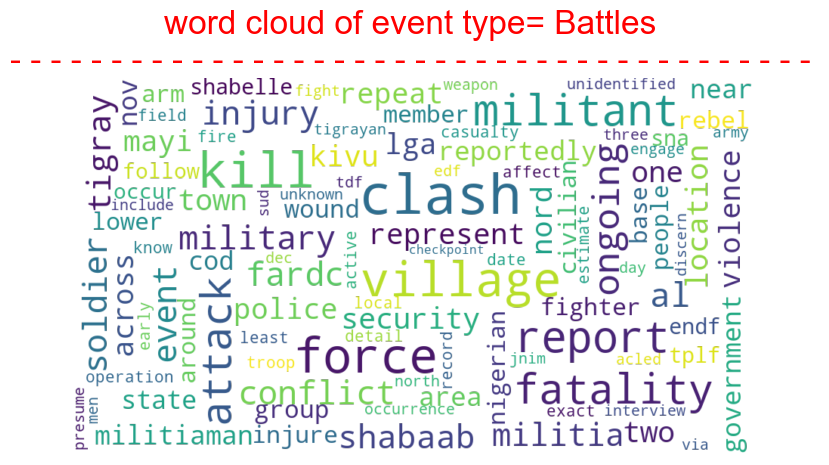

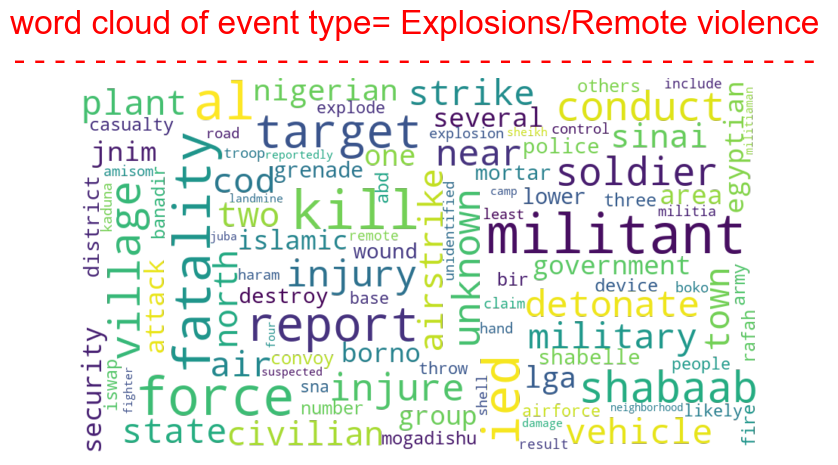

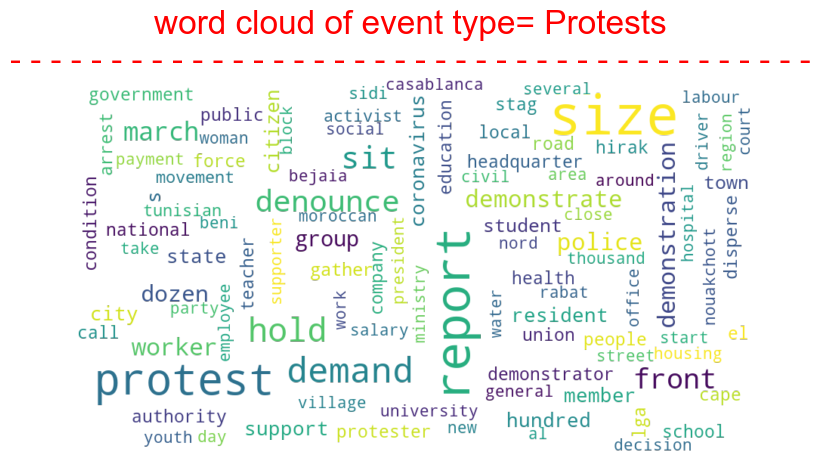

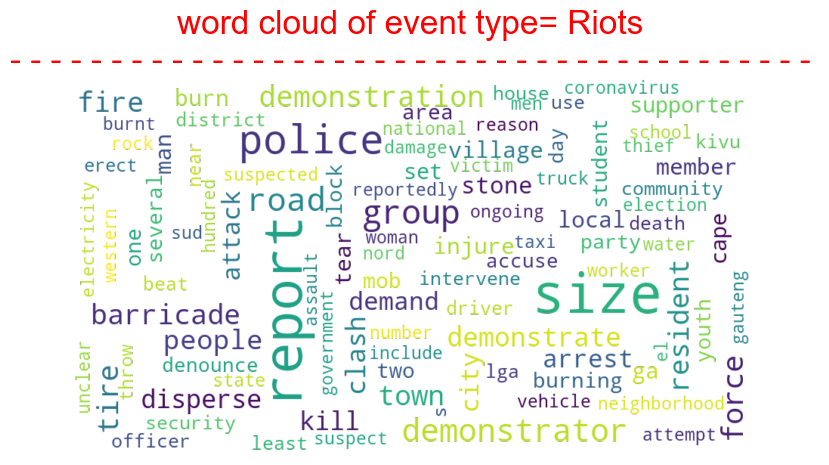

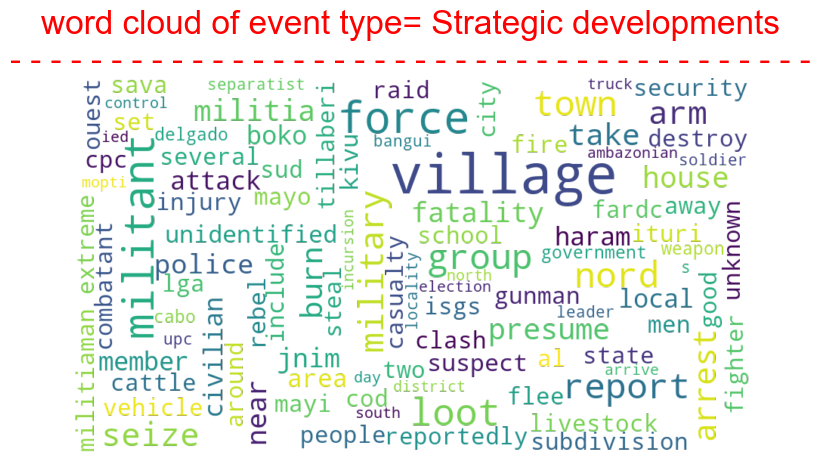

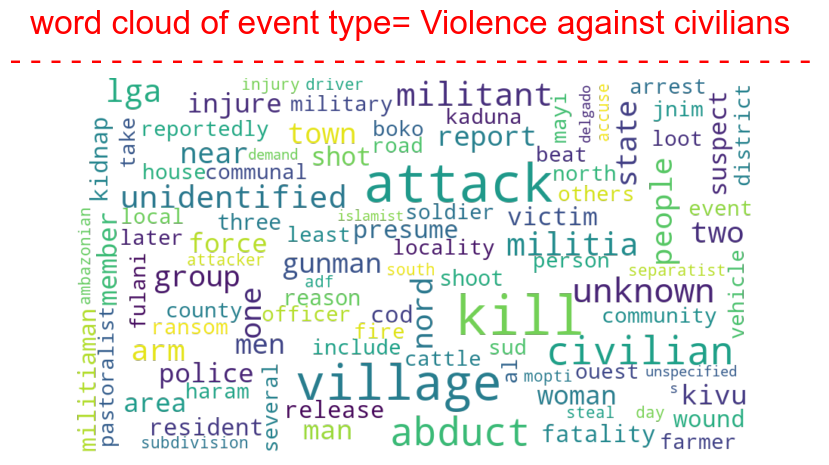

In [20]:

for k in event_type_notes.keys():
    
    text=" ".join(event_type_notes[k])

    wc = WordCloud(width=900, height=500, 
                   mode='RGBA', background_color=None,
                   min_font_size=12,max_font_size=72,
                   collocations=False,prefer_horizontal=0.8,
                   max_words=100).generate(text)

    # show wordcloud img
    plt.figure(figsize=(9,5),dpi=100)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title("word cloud of event type= {} \n{}".format(k,'- '*40),fontsize=24,color='red')
    plt.show()
    print()

# classification model 

+ ["Protests","Battles"]
+ Classification model of these two kinds of events

## classification model(only 2 event types)

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

# from sklearn.naive_bayes import MultinomialNB
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,auc,accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV

In [22]:
# Define two functions that will be used later in the drawing

def plotConfusionMaxtrix(confmat_data=None,xlabel='',ylabel='',title='',cmap=plt.cm.Blues,plt_ax=None):
    """
    Used for drawing - confusion matrix
    """
    plt_ax.matshow(confmat_data, cmap=cmap, alpha=0.75)
    for i in range(confmat_data.shape[0]):
        for j in range(confmat_data.shape[1]):
            plt_ax.text(x=j, y=i,s=confmat_data[i, j],va='center', ha='center',fontsize=12)
    plt_ax.set_xlabel(xlabel,fontsize=12)
    plt_ax.set_ylabel(ylabel,fontsize=12)
    plt_ax.set_title(title,fontsize=12)
    return 


def plotRocBinary(fpr=None,tpr=None,roc_auc=None,color='red',title='',plot_ax=None):
    plot_ax.plot(fpr, tpr, c=color,linewidth=2,label='ROC Curve (auc = %0.3f)' % roc_auc)
    plot_ax.plot([0, 1], [0, 1], 'k--',label='Random Prediction')
    plot_ax.set_xlim([0.0, 1.0])
    plot_ax.set_ylim([0.0, 1.0])
    plot_ax.set_xlabel('1 - Specifity',fontsize=12)
    plot_ax.set_ylabel('Sensitivity',fontsize=12)
    plot_ax.set_title(title,fontsize=12)
    for key in ["left","right","top","bottom"]:
        plot_ax.spines[key].set_alpha(0.3)
    plot_ax.legend(loc="lower right")
    return

In [23]:
# perpare x and y 
data_model=data_sub[data_sub["event_type"].isin(["Protests","Battles"])][["notes_clean","event_type"]].copy()
x=data_model["notes_clean"]
y=data_model["event_type"].map({"Protests":0,"Battles":1})

# split train set and test set
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=1)

In [24]:
# Extract text features using TFIDF

vectorizer = TfidfVectorizer(min_df=3,max_df=0.3)
xtrain_vectorizer=vectorizer.fit_transform(xtrain)
xtest_vectorizer =vectorizer.transform(xtest)

In [25]:
# Random forest was used as the classification model, and the super parameters were adjusted to make the model best

rf=RandomForestClassifier(random_state=42)

# set tune parameter
parameters = {'max_depth': range(3,51)}

grid_rf = GridSearchCV(rf, parameters,cv=5, n_jobs=-1)
grid_rf.fit(xtrain_vectorizer,ytrain)

# The optimal depth is 38
print("best_params: ",grid_rf.best_params_)

best_params:  {'max_depth': 38}


+ This section also takes a long time to do hyperparameter tuning

In [26]:
# Look at the model's classification report on training data and test data

pred_ytrain_grid_rf=grid_rf.predict(xtrain_vectorizer)
pred_ytest_grid_rf=grid_rf.predict(xtest_vectorizer)

proba_ytrain_grid_rf=grid_rf.predict_proba(xtrain_vectorizer)
proba_ytest_grid_rf=grid_rf.predict_proba(xtest_vectorizer)

print("="*60)
print(" "*5,"Train Data Classification Report")
print(classification_report(ytrain,pred_ytrain_grid_rf))
print("="*60)

print(" "*5,"Test Data Classification Report")
print(classification_report(ytest,pred_ytest_grid_rf))
print("="*60)

      Train Data Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8036
           1       1.00      1.00      1.00      5255

    accuracy                           1.00     13291
   macro avg       1.00      1.00      1.00     13291
weighted avg       1.00      1.00      1.00     13291

      Test Data Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3504
           1       0.99      0.99      0.99      2193

    accuracy                           1.00      5697
   macro avg       1.00      1.00      1.00      5697
weighted avg       1.00      1.00      1.00      5697



+ This seems to work very well for both Battles and Protests, and the accuracy of both is 100% in the test set
+ Notice the previous definition: 0 means Protests, 1 means Battles

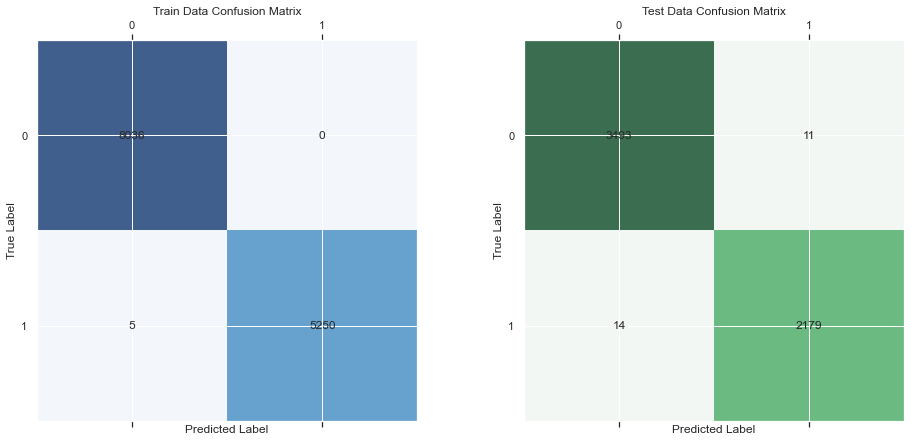

In [27]:
# Visualize the confusion matrix

confmat_train = confusion_matrix(y_true=ytrain, y_pred=pred_ytrain_grid_rf)
confmat_test = confusion_matrix(y_true=ytest, y_pred=pred_ytest_grid_rf)

# Plot Confusion Matrix
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16, 7))
#plot for train data
plotConfusionMaxtrix(confmat_data=confmat_train,
                     xlabel='Predicted Label',
                     ylabel='True Label',
                     title='Train Data Confusion Matrix',
                     cmap=plt.cm.Blues,
                     plt_ax=ax1)
#plot for test data
plotConfusionMaxtrix(confmat_data=confmat_test,
                     xlabel='Predicted Label',
                     ylabel='True Label',
                     title='Test Data Confusion Matrix',
                     cmap=plt.cm.Greens,
                     plt_ax=ax2)
plt.show()

+ A few predictions were wrong, but the overall model worked pretty well

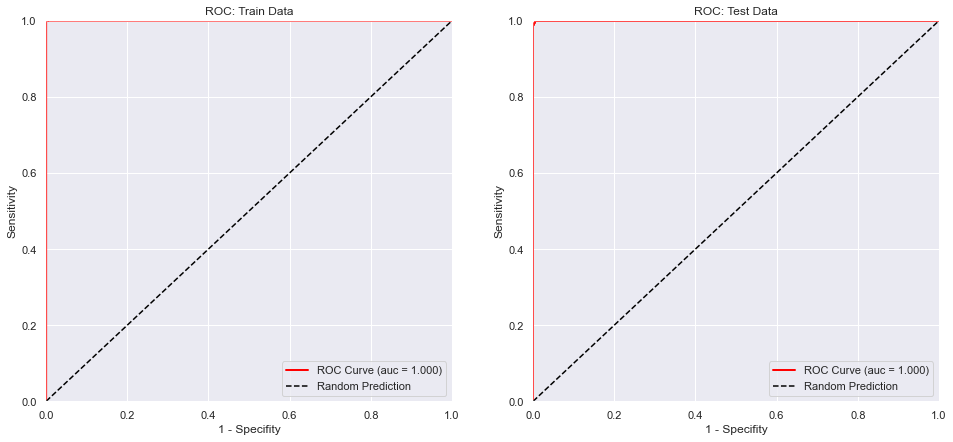

In [28]:
# roc curve

fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16, 7))

# Plot ROC curve - train data
fpr, tpr, thresholds = roc_curve(ytrain, proba_ytrain_grid_rf[:,1])
roc_auc = auc(fpr,tpr)
plotRocBinary(fpr=fpr,tpr=tpr,roc_auc=roc_auc,color='red',title='ROC: Train Data',plot_ax=ax1)

# Plot ROC curve - test data
fpr, tpr, thresholds = roc_curve(ytest, proba_ytest_grid_rf[:,1])
roc_auc = auc(fpr,tpr)
plotRocBinary(fpr=fpr,tpr=tpr,roc_auc=roc_auc,color='red',title='ROC: Test Data',plot_ax=ax2)

plt.show()

+ roc curve is also very good

+ Overall, the effect of the dichotomy model of the two events is very good. Based on the contents of Notes, it can perfectly identify whether an event is protest or battle

## classification model(6 event types)

In [29]:
# A function that defines the ROC of a multi-classification problem The ROC of multi-classification is not the same as the ROC of dichotomies

def plotRocMulti(fpr=None,tpr=None,roc_auc=None,title='',plot_ax=None):
    # plot Roc for each category
    colors=['peru','darkcyan','cyan','purple','red','blue']
    for i, color in zip(range(6), colors):
        plot_ax.plot(fpr[i], tpr[i], color=color, lw=2,label='ROC curve of Class:{0}(auc = {1:0.3f})'.format(i, roc_auc[i]))

    plot_ax.plot([0, 1], [0, 1], 'k--', lw=1)
    plot_ax.set_xlim([0.0, 1.0])
    plot_ax.set_ylim([0.0, 1.0])
    plot_ax.set_xlabel('1 - Specifity',fontsize=12)
    plot_ax.set_ylabel('Sensitivity',fontsize=12)
    plot_ax.set_title(title,fontsize=12)
    for key in ["left","right","top","bottom"]:
        plot_ax.spines[key].set_alpha(0.3)
    plot_ax.legend(loc="lower right")
    return

In [30]:
# perpare x and y 
data_model_6=data_sub[["notes_clean","event_type"]].copy()
x=data_model_6["notes_clean"]
y=data_model_6["event_type"].map({"Protests":0,
                                  "Battles":1,
                                  "Violence against civilians":2,
                                  "Riots":3,
                                  "Strategic developments":4,
                                  "Explosions/Remote violence":5})

# split train set and test set
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=1)

In [31]:
# How many records are there for each of the six event types? Now it seems that the sample size of each category is quite different. Let's try modeling first (because the previous two classification models are very effective)

data_model_6["event_type"].value_counts()

Protests                      11540
Battles                        7448
Violence against civilians     7141
Riots                          3928
Strategic developments         1778
Explosions/Remote violence     1543
Name: event_type, dtype: int64

In [32]:
# Extract text features using TFIDF

vectorizer6 = TfidfVectorizer(min_df=3,max_df=0.3)
xtrain_vectorizer6=vectorizer6.fit_transform(xtrain)
xtest_vectorizer6 =vectorizer6.transform(xtest)

In [33]:
# Random forest was used as the classification model, and the super parameters were adjusted to make the model best

rf=RandomForestClassifier(random_state=42)

# set tune parameter
parameters = {'max_depth': range(5,101,2)}

grid_rf6 = GridSearchCV(rf, parameters,cv=5, n_jobs=-1)
grid_rf6.fit(xtrain_vectorizer6,ytrain)

# The optimal depth is 97
print("best_params: ",grid_rf6.best_params_)

best_params:  {'max_depth': 97}


In [34]:
# Look at the model's classification report on training data and test data

pred_ytrain_grid_rf6=grid_rf6.predict(xtrain_vectorizer6)
pred_ytest_grid_rf6=grid_rf6.predict(xtest_vectorizer6)

print("="*60)
print(" "*5,"Train Data Classification Report")
print(classification_report(ytrain,pred_ytrain_grid_rf6))
print("="*60)

print(" "*5,"Test Data Classification Report")
print(classification_report(ytest,pred_ytest_grid_rf6))
print("="*60)

      Train Data Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8016
           1       1.00      1.00      1.00      5240
           2       1.00      1.00      1.00      5002
           3       1.00      1.00      1.00      2756
           4       1.00      1.00      1.00      1258
           5       1.00      1.00      1.00      1092

    accuracy                           1.00     23364
   macro avg       1.00      1.00      1.00     23364
weighted avg       1.00      1.00      1.00     23364

      Test Data Classification Report
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      3524
           1       0.90      0.93      0.92      2208
           2       0.83      0.94      0.88      2139
           3       0.94      0.77      0.85      1172
           4       0.93      0.52      0.67       520
           5       0.93      0.82      0.87       451



+ The overall accuracy of the model is still 91% on the test set (but the sample is not balanced. The best we can do is refer to f1-Score.)
+ Explosions and Explosions Explosions and Remote violence are the main types of Explosions and Explosions in this week's Explosions and Explosions Explosions

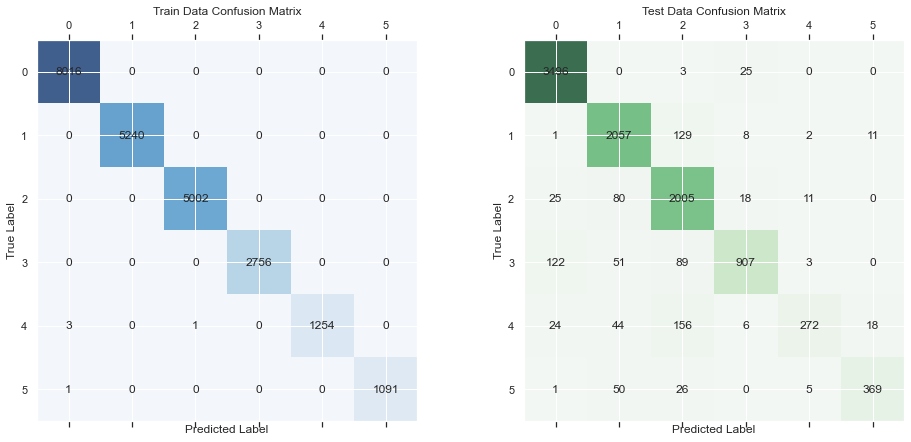

In [35]:
# Visualize the confusion matrix

confmat_train6 = confusion_matrix(y_true=ytrain, y_pred=pred_ytrain_grid_rf6)
confmat_test6 = confusion_matrix(y_true=ytest, y_pred=pred_ytest_grid_rf6)

# Plot Confusion Matrix
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16, 7))
#plot for train data
plotConfusionMaxtrix(confmat_data=confmat_train6,
                     xlabel='Predicted Label',
                     ylabel='True Label',
                     title='Train Data Confusion Matrix',
                     cmap=plt.cm.Blues,
                     plt_ax=ax1)
#plot for test data
plotConfusionMaxtrix(confmat_data=confmat_test6,
                     xlabel='Predicted Label',
                     ylabel='True Label',
                     title='Test Data Confusion Matrix',
                     cmap=plt.cm.Greens,
                     plt_ax=ax2)
plt.show()

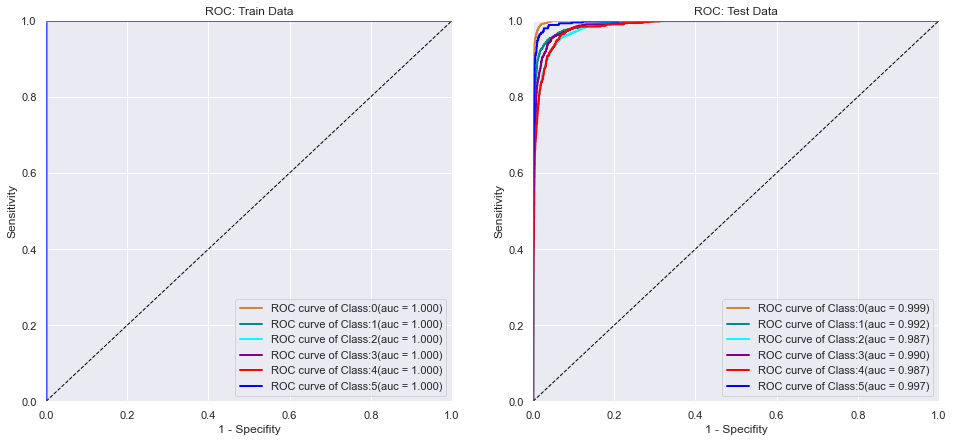

In [36]:
from sklearn.preprocessing import label_binarize

proba_ytrain_grid_rf6=grid_rf6.predict_proba(xtrain_vectorizer6)
proba_ytest_grid_rf6=grid_rf6.predict_proba(xtest_vectorizer6)

# Training data ROC
train_fpr = dict()
train_tpr = dict()
train_roc_auc = dict()
ytrain_bin = label_binarize(ytrain, classes=[0, 1, 2,3,4,5])
# Calculate the FPR TPR AUC for each category
for i in range(6):
    train_fpr[i], train_tpr[i], _ = roc_curve(ytrain_bin[:, i], proba_ytrain_grid_rf6[:, i])
    train_roc_auc[i] = auc(train_fpr[i], train_tpr[i])
    
# Test the ROC of data
test_fpr = dict()
test_tpr = dict()
test_roc_auc = dict()
ytest_bin = label_binarize(ytest, classes=[0, 1, 2,3,4,5])
# Calculate the FPR TPR AUC for each category
for i in range(6):
    test_fpr[i], test_tpr[i], _ = roc_curve(ytest_bin[:, i], proba_ytest_grid_rf6[:, i])
    test_roc_auc[i] = auc(test_fpr[i], test_tpr[i])
    
# draw
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16, 7))
plotRocMulti(fpr=train_fpr,tpr=train_tpr,roc_auc=train_roc_auc,title='ROC: Train Data',plot_ax=ax1)
plotRocMulti(fpr=test_fpr,tpr=test_tpr,roc_auc=test_roc_auc,title='ROC: Test Data',plot_ax=ax2)

## classification model(6 event types deal with imbalanced problem)

In [37]:
# imblearn Used to deal with unbalanced sample problems

from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [38]:
# A balanced sample training model is constructed by random falling sampling

# The first step in building a pipeline is to do random drop sampling and the second step is classifier
rf_pipe = Pipeline(
    [
        ('sampling', RandomUnderSampler(random_state=42)),
        ('classifier', RandomForestClassifier(random_state=42))   
    ])

# search for best parameters by GridSearchCV
parameters = {'classifier__max_depth': range(5,101,2)}

grid_rf_pipe = GridSearchCV(rf_pipe, parameters,cv=5,n_jobs=-1)
grid_rf_pipe.fit(xtrain_vectorizer6,ytrain)

# The optimal depth is 95
print("best_params: ",grid_rf_pipe.best_params_)

best_params:  {'classifier__max_depth': 95}


In [39]:
# Look at the model's classification report on training data and test data

pred_ytrain_grid_rf_pipe=grid_rf_pipe.predict(xtrain_vectorizer6)
pred_ytest_grid_rf_pipe=grid_rf_pipe.predict(xtest_vectorizer6)

proba_ytrain_grid_rf_pipe=grid_rf_pipe.predict_proba(xtrain_vectorizer6)
proba_ytest_grid_rf_pipe=grid_rf_pipe.predict_proba(xtest_vectorizer6)

print("="*60)
print(" "*5,"Train Data Classification Report")
print(classification_report(ytrain,pred_ytrain_grid_rf_pipe))
print("="*60)

print(" "*5,"Test Data Classification Report")
print(classification_report(ytest,pred_ytest_grid_rf_pipe))
print("="*60)

      Train Data Classification Report
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      8016
           1       0.96      0.88      0.92      5240
           2       0.91      0.88      0.90      5002
           3       0.87      0.89      0.88      2756
           4       0.73      0.98      0.84      1258
           5       0.82      1.00      0.90      1092

    accuracy                           0.92     23364
   macro avg       0.88      0.93      0.90     23364
weighted avg       0.93      0.92      0.92     23364

      Test Data Classification Report
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      3524
           1       0.93      0.86      0.89      2208
           2       0.89      0.84      0.86      2139
           3       0.82      0.83      0.83      1172
           4       0.62      0.87      0.73       520
           5       0.75      0.95      0.84       451



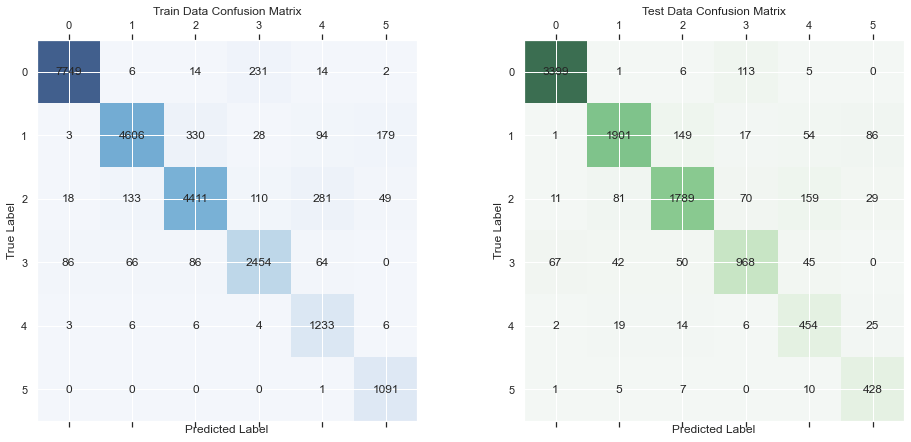

In [40]:
# Visualize the confusion matrix

confmat_train_pipe = confusion_matrix(y_true=ytrain, y_pred=pred_ytrain_grid_rf_pipe)
confmat_test_pipe = confusion_matrix(y_true=ytest, y_pred=pred_ytest_grid_rf_pipe)

# Plot Confusion Matrix
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16, 7))
#plot for train data
plotConfusionMaxtrix(confmat_data=confmat_train_pipe,
                     xlabel='Predicted Label',
                     ylabel='True Label',
                     title='Train Data Confusion Matrix',
                     cmap=plt.cm.Blues,
                     plt_ax=ax1)
#plot for test data
plotConfusionMaxtrix(confmat_data=confmat_test_pipe,
                     xlabel='Predicted Label',
                     ylabel='True Label',
                     title='Test Data Confusion Matrix',
                     cmap=plt.cm.Greens,
                     plt_ax=ax2)
plt.show()

+ It is easy to see from the results of the confusion matrix of the test data that the values of the main diagonals of some events increase and some decrease
+ If we expect events of the latter two categories (with smaller sample size) to be accurately identified, then we use the model processed with unbalanced samples. If there is no preference for the recognition of each category, we use the model processed with balanced samples, because the samples of the latter two event categories are relatively small

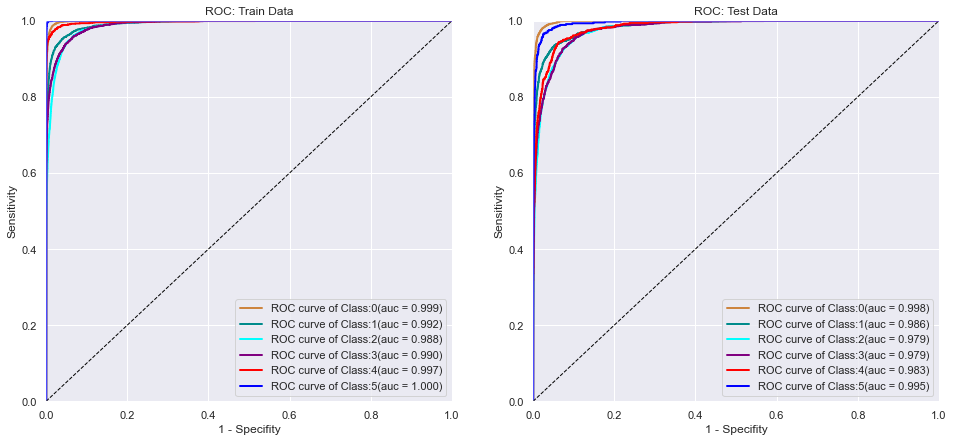

In [41]:
# Predict the probability of each class of events
proba_ytrain_grid_rf_pipe=grid_rf_pipe.predict_proba(xtrain_vectorizer6)
proba_ytest_grid_rf_pipe=grid_rf_pipe.predict_proba(xtest_vectorizer6)

# Training data ROC
train_fpr = dict()
train_tpr = dict()
train_roc_auc = dict()
ytrain_bin = label_binarize(ytrain, classes=[0, 1, 2,3,4,5])
# Calculate the FPR TPR AUC for each category
for i in range(6):
    train_fpr[i], train_tpr[i], _ = roc_curve(ytrain_bin[:, i], proba_ytrain_grid_rf_pipe[:, i])
    train_roc_auc[i] = auc(train_fpr[i], train_tpr[i])
    
# Test the ROC of data
test_fpr = dict()
test_tpr = dict()
test_roc_auc = dict()
ytest_bin = label_binarize(ytest, classes=[0, 1, 2,3,4,5])
# Calculate the FPR TPR AUC for each category
for i in range(6):
    test_fpr[i], test_tpr[i], _ = roc_curve(ytest_bin[:, i], proba_ytest_grid_rf_pipe[:, i])
    test_roc_auc[i] = auc(test_fpr[i], test_tpr[i])
    
# draw
fig, (ax1, ax2) = plt.subplots(nrows=1,ncols=2,figsize=(16, 7))
plotRocMulti(fpr=train_fpr,tpr=train_tpr,roc_auc=train_roc_auc,title='ROC: Train Data',plot_ax=ax1)
plotRocMulti(fpr=test_fpr,tpr=test_tpr,roc_auc=test_roc_auc,title='ROC: Test Data',plot_ax=ax2)

+ Overall, the model still performs well. If more training data can be added, several events with relatively small sample size will be more accurate